# Celestia - Classification of Celestial Objects Machine Learning Project
#### Names: Hai Hoang, Eddie Cazares, Katherine Clark, Adi Behre

## Purpose
The Sloan Digital Sky Survey (SDSS) has produced a massive catalog of celestial objects. With millions of objects recorded, it's not feasible to classify them all manually.\
The goal here is to use machine learning techniques in order to build a model that can automatically classify an object as star, galaxy, and quasar. We will be using a public dataset of 100,000 objects from SDSS (DR18). Our process will be to clean the data, explore its key patterns, and train on several different machine learning models. The best model will be the one that can effectively use an object's features (like colors and redshift) to make an accurate prediction.

### Data Source

This notebook uses the **Sloan Digital Sky Survey - DR18** dataset, which is publicly available on Kaggle.
*   **Dataset Name:** Sloan Digital Sky Survey - DR18
*   **Original Creator:** diraf0
*   **Source:** [Sloan Digital Sky Survey - DR18](https://www.kaggle.com/datasets/diraf0/sloan-digital-sky-survey-dr18/data)
*   **Access Date:** November 11, 2024

#### About this dataset

This dataset consists of 100,000 observations from the Data Release 18 of the Sloan Digital Sky Survey (SDSS).
Each observation is described by 42 features and 1 class column classifying the observation as either:

- a STAR
- a GALAXY
- a Quasi-Stellar Object (QSO) or a Quasar.

First, we will load the necessary libraries for our project.

In [32]:
# --- Data Loading ---
import pandas as pd
import math
import numpy as np

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ROCAUC

# --- Train models ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.impute import SimpleImputer
# --- Second model ---
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline

# --- Synthetic Data Creation ---
from imblearn.over_sampling import SMOTE

# --- Hyperparameter Tuning ---
import optuna

## 1 Data Cleaning and Preparation
- Check if there are any missing, NaN, or duplicate values in the dataset.
- Classification feature must include only GALAXY, STAR, QSO.
- Handle any error data points, identified values of -9999 and covert to median.
- Learn more about the features and ask "Would this be useful for the model to train on"?

In [3]:
# --- Load Data ---
dataset = pd.read_csv("SDSS_DR18.csv")

print("Checking for missing values: ", dataset.isnull().sum().sum())
print("Checking for any NaN values: ", dataset.isna().sum().sum())
print("Number of duplicates: ", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

# Checking for inconsistencies (should only yield GALAXY, STAR, and QSO)
classes = ["STAR", "GALAXY", "QSO"]
dataset['class'] = dataset['class'].str.strip().str.upper()
print("Unique classes:", dataset['class'].unique())

# Checking data types for each col/features
print("Datatypes in dataset:")
print(dataset.dtypes.value_counts())

Checking for missing values:  0
Checking for any NaN values:  0
Number of duplicates:  0
Unique classes: ['GALAXY' 'STAR' 'QSO']
Datatypes in dataset:
float64    35
int64       7
object      1
Name: count, dtype: int64


In [4]:
# Noticed there were error values in boxplots on kaggle.
error_checking_column = dataset.drop(columns=['class'])
error_counts = (error_checking_column == -9999).sum()
error_counts = error_counts[error_counts > 0]
print(f"Count of '-9999' values in each column: {error_counts.sum()}")

dataset.replace(-9999, np.nan, inplace=True)

Count of '-9999' values in each column: 235


After exploring the dataset's features/columns, we have decided that to drop objid, spaceobjid, run, rerun, camcol, field, plate, mjd, fiberid since they are mostly observational metadata and are not part of the physical properties of the object.\
What we should have left are the physical attributes of each object.

In [5]:
drop_columns = ['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field', 'plate', 'mjd', 'fiberid']
dataset = dataset.drop(columns=drop_columns, errors='ignore')
print(dataset.columns)

Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'petroRad_u', 'petroRad_g',
       'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g',
       'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g',
       'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r',
       'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r',
       'expAB_i', 'expAB_z', 'redshift', 'class'],
      dtype='object')


## 2 Exploratory Data Analysis (EDA) and Feature Engineering
After cleaning and fixing the data, the next step would be to perform Exploratoday Data Analysis (EDA). The goal of this phase is to dig deeper into the data in order to understand its strucuture, find patterns, and identify potential issues that need to be addressed before modeling. The insights from EDA will guide decisions on feature engineering and final data preparation.\
\
Key Questions to Answer:
- **Class Balance:** How are the three classes (STAR, GALAXY, QSO) distributed? Is there a significant imbalance?
- **Feature Distributions:** What do the distributions of key features, like redshift, look like? How do they differ for each class?
- **Correlations:** Are there strong correlations between features that might indicate redundancy?

#### Notes
- ugriz photometry used to infer surface temperature and other physical properties, "as well as identify and classify different types of celestial objects".
    - u: ultraviolet, g: green light, r: red light, i: near-infrared light, z: further infrared light
    - each physical property is measured independently through each of the five color filters
- psfMag (or Point Spread Function) magnitudes help in characterizing brightness and colors of objects. Useful for stars.
- petroRad (or Petrosian radius) is the measurement of the size of a galaxy and is calculated using the petrosian flux profile.
- petroR50 (or Petrosian half-light radius) is the measure of angular size of an image and are from surface brightness profile of the galaxy, which may most meaningful for galaxies.
- petroFlux (or Petrosian Flux) is the total amount of light (Flux) recieved from an object.
-expAB is the axios ratio -> completely round object would have a ratio of 1.0, while a more flattened, elliptical object will have value less than 1.0.

In [6]:
dataset.describe()

,ra,dec,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_i,...,psfMag_r,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99999.000000,99997.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,99999.000000,99997.000000,100000.000000,100000.000000,100000.000000,99999.000000,99997.000000,100000.000000
mean,168.856657,17.832739,18.641137,17.407088,16.878550,16.617293,16.455301,6.497004,4.678636,4.458623,...,17.884605,18.392280,17.631530,17.438986,0.588445,0.673314,0.660934,0.649126,0.611377,0.168441
std,83.844216,26.344079,0.829035,0.974683,1.118858,1.193332,1.268950,13.134345,5.080707,5.189891,...,1.288541,1.282606,1.279304,1.265996,0.260097,0.235317,0.242927,0.245506,0.260907,0.434285
min,0.003092,-11.252825,11.726470,11.696170,11.277090,11.051390,10.616260,0.031018,0.072805,0.057369,...,11.253550,11.658570,11.062340,10.780100,0.050000,0.050000,0.050000,0.050000,0.050000,-0.004268
25%,128.879582,-0.537780,18.214315,16.853340,16.194763,15.862010,15.620310,1.580248,1.483575,1.301338,...,17.098733,17.600867,16.842320,16.645670,0.387406,0.514009,0.487474,0.470533,0.409981,0.000065
50%,168.079889,2.899490,18.878005,17.520310,16.896065,16.594740,16.419080,3.473864,3.336594,3.349003,...,18.023495,18.585375,17.742680,17.526410,0.611638,0.704848,0.692239,0.679104,0.641455,0.048772
75%,214.554569,46.911371,19.275750,18.052460,17.565593,17.310115,17.193880,7.470103,6.570969,6.196268,...,18.858960,19.327640,18.586035,18.366250,0.796679,0.864902,0.863116,0.849946,0.822495,0.096680
max,359.996095,68.731483,19.599990,19.977270,31.698160,30.980870,28.668700,258.518600,258.409800,258.453600,...,24.802850,25.962180,24.362590,27.043280,1.000000,1.000000,1.000000,1.000000,1.000000,6.990327


### 2.1 Class Imbalance
Our dataset revealed a significant class imbalance, with GALAXY being the majority class and QSO being the distinct minority. Using accuracy as a primary metric would be misleading, as a model could achieve a high score by simply predicting the majority class. Therefore, we will use more robust metrics, which are precision, recall, and F1-score, in order to get a true measurement of the model's performance on all classes. To address the imbalance during training, we will use SMOTE (Synthetic Minority Oversampling Technique). This method will be applied only to training data to create new, synthetic examples of the minority classes (STAR and QSO), providing a balanced dataset for the model to learn.

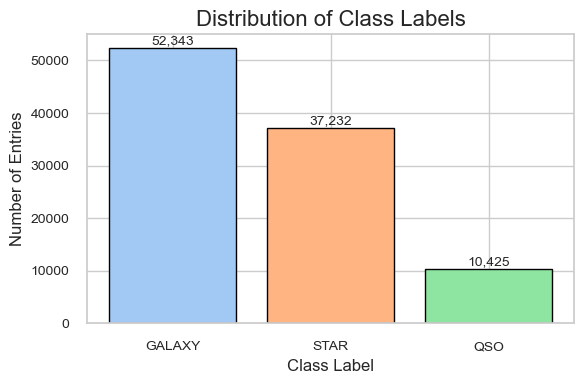

In [7]:
sns.set_theme(style="whitegrid")
class_counts = dataset['class'].value_counts()
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index, class_counts.values, color=sns.color_palette("pastel"), edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:,}',
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Class Labels", fontsize=16)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Entries", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [8]:
# --- Percentage of Class Labels ---
print('Galaxy:', round(dataset['class'].value_counts().iloc[0] / len(dataset) * 100, 2), '% of the dataset')
print('Star:', round(dataset['class'].value_counts().iloc[1] / len(dataset) * 100, 2), '% of the dataset')
print('Quasar:', round(dataset['class'].value_counts().iloc[2] / len(dataset) * 100, 2), '% of the dataset')

Galaxy: 52.34 % of the dataset
Star: 37.23 % of the dataset
Quasar: 10.42 % of the dataset


### 2.2 Heatmap
To better understand the relationships between different numerical features in our dataset, we can compute a correlation matrix and visualize it as a heatmap. This plot helps us identify features that provide redundant information, where we need to prepare the steps for our model to learn. The heatmap reveals several large blocks of bright red, indicating high correlations between certain groups.

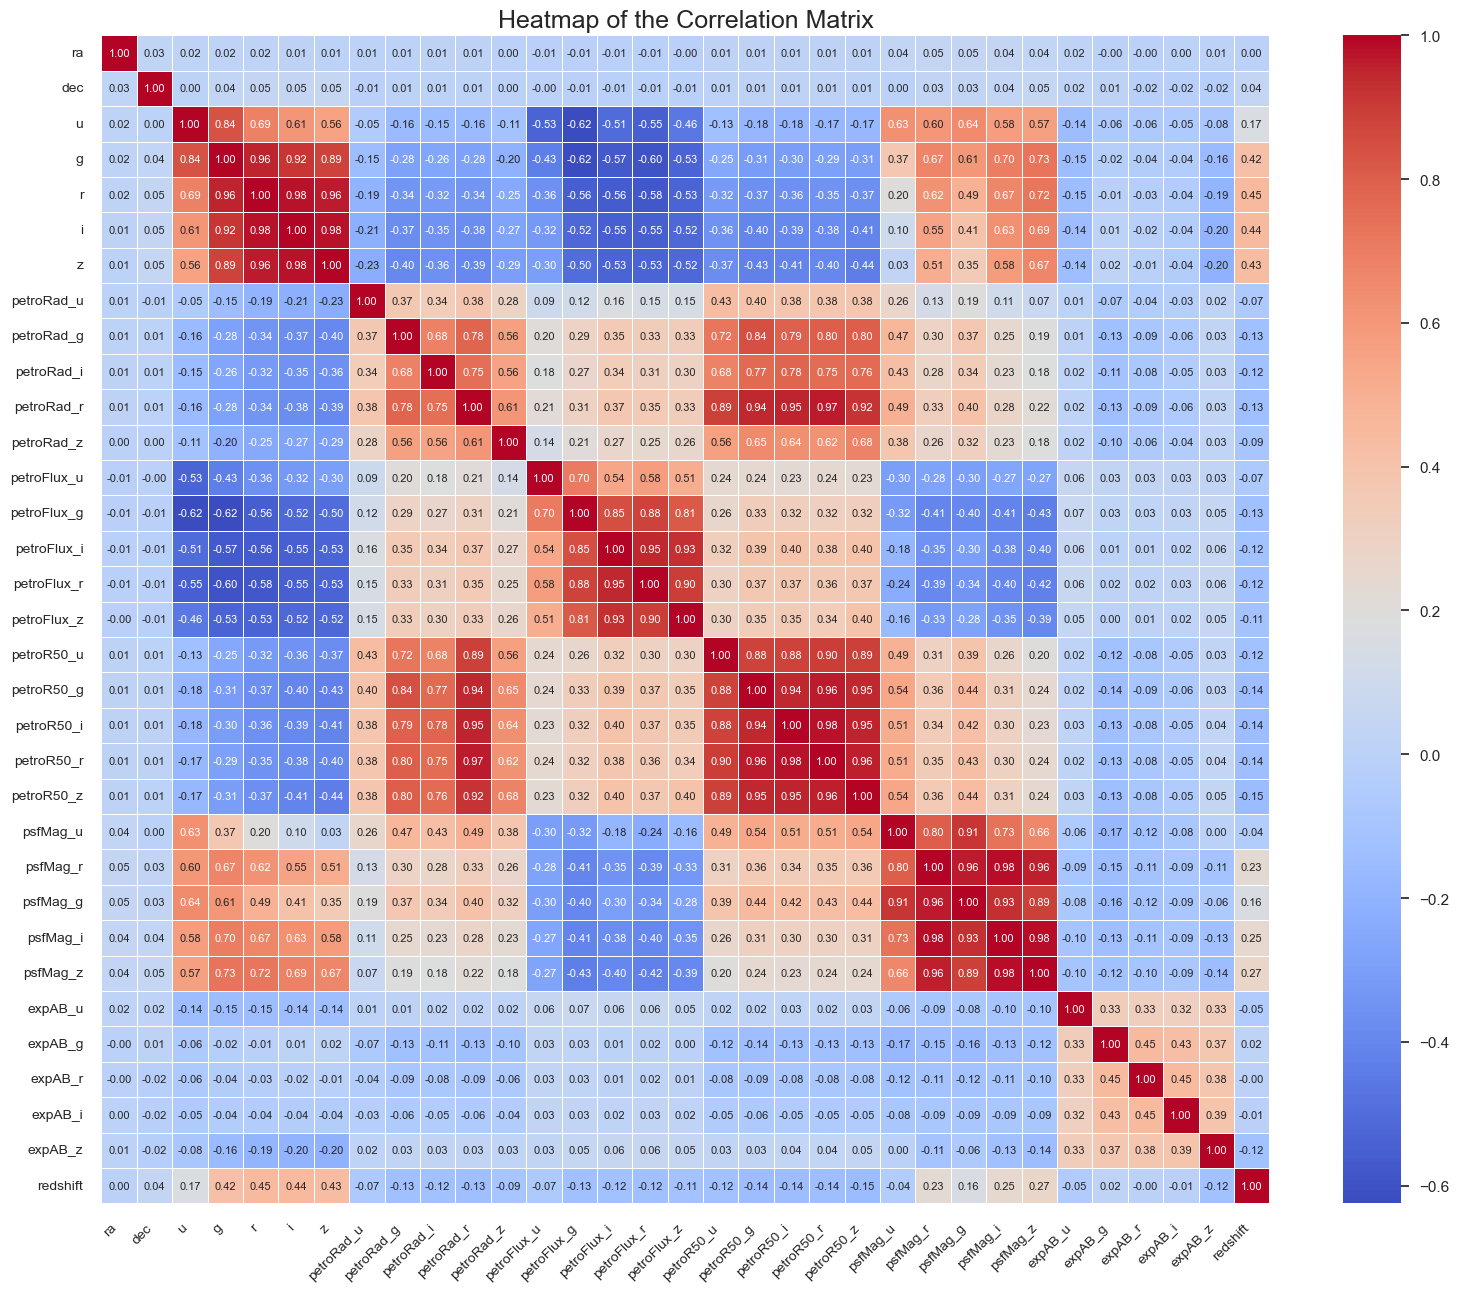

In [9]:
numeric_columns = dataset.select_dtypes(include=["int64", "float64"]).columns
correlation_matrix = dataset[numeric_columns].corr()
round(correlation_matrix, 2)
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, annot_kws={"size": 8}, linewidths=0.5)
plt.title("Heatmap of the Correlation Matrix", fontsize=18)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

### 2.3 3D Positional Map of Celestial Objects
The dataset contains the 2D coordinates of each object on the celestial sphere (RA and DEC), which are like longitude and latitude for the sky. The redshift feature provides an important third dimension, which is distance.\
Due to the expansion of the universe, light from distant objects gets stretched to longer, redder wavelengths as it travels towards us. The amount of this "redshift" is directly related to the object's distance, a principle described by *Hubble's Law*.\
This analysis will use a simplified version of Hubble's Law to convert each object's redshift into an approximate distance in Megaparsecs (Mpc). By plotting the object's 2D positions along with the calculated distance, we can create a 3D map to visualize their spatial distribution.\
\
This 3D scatter plot confirms that the three classes of objects occupy distinct regions in space relative to us. The plot uses Right Ascension (RA) and Declination (DEC) for the 2D sky position, while redshift is used as an approximation for distance on the z-axis.\
Some of the key observations are:
- Stars (yellow) are all located in a very thin layer at the bottom of the plot, corresponding to a distance of almost zero. This is expected, as all the stars in this dataset are within our own galaxy and are close in a cosmo sense.
- Galaxies (blue) are distributed at low to moderate distances.
- Quasars (red) are scattered at the farthest distances on the plot. This confirms that quasars are the most distant objects in the dataset, which is why they have the highest redshift values.
- Survey Shape: The overall "striped" or "wedge" shape of the data points is a direct reflection of the way the Sloan Digital Sky Survey (SDSS) scans the sky. It doesn't observe the entire sky but focuses on specific regions, and this plot accurately shows those survey areas. (More focus on the northern regions since the telescope is located in New Mexico, US)

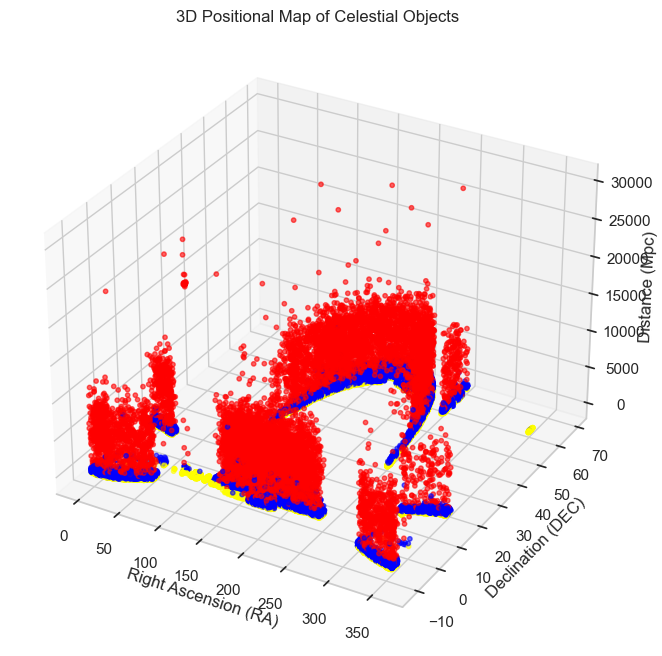

In [10]:
c = 3e5     # Speed of light
H0 = 70     # Hubble constant, rate of universe's expansion

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(dataset['ra'], dataset['dec'], (c * dataset['redshift']) / H0, c=dataset['class'].map({'STAR': 'yellow', 'GALAXY': 'blue', 'QSO': 'red'}), alpha=0.6,s=10
)

ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (DEC)')
ax.set_zlabel('Distance (Mpc)')
ax.set_title('3D Positional Map of Celestial Objects')
plt.show()

### 2.4 Extended Objects vs. Point-like Objects

A challenge in classification is distinguishing point-like objects (stars and quasars) from extended objects (galaxies). At great distances, a galaxy appear as a single point of light, just like a star. To solve this, we can engineer a new feature based on how the SDSS pipeline measures brightness. The pipeline calculates two key magnitudes:
- psfMag: "Point Spread Function" magnitude. This measures the object's brightness by fitting the image with a model of a perfect point source.
- modelMag: This is the magnitude from whichever model fits best (either the psfMag or a more complex model for an extended galaxy).

By subtracting these two, we can create a powerful feature that separates the classes.\
\
Analysis: Our analysis shows the Δ-Mag features are a powerful tool for classifying objects. The histograms and scatter plot both confirm that these features can isolate extended sources (Galaxies) from point-like sources (Stars and Quasars). However, the plots also show that stars and quasars are indistinguishable using this feature alone. Therefore, to achieve the final goal of separating stars from quasars, the model must rely on the photometric color indices (e.g., u-g, g-r). The final model should use both the Δ-Mag features (to remove galaxies) and the color indices (to separate stars and quasars).

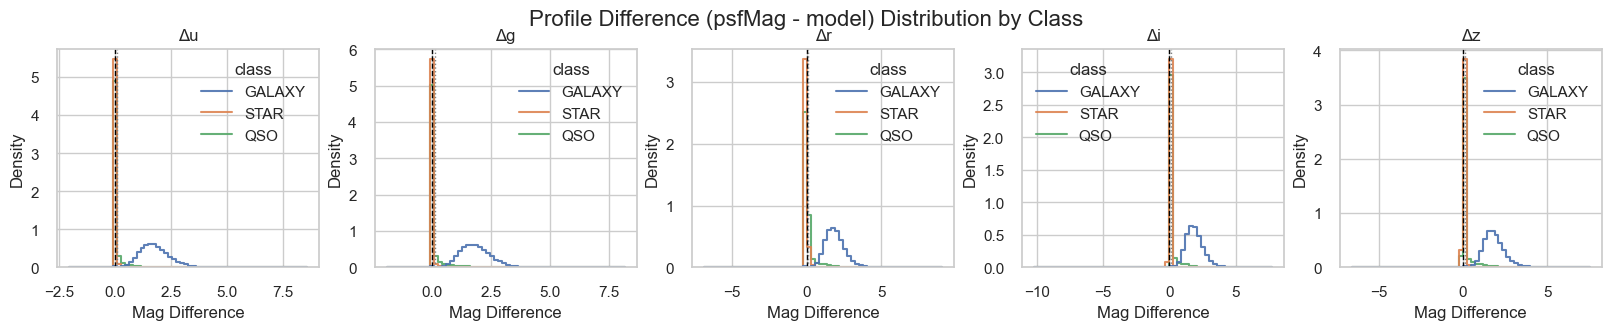

In [11]:
# --- Load for Feature Engineering ---
df_processed = dataset.copy()

# --- Engineer Profile Difference Feature (Delta-Mag) ---
for band in ['u', 'g', 'r', 'i', 'z']:
    df_processed[f'Δ{band}'] = df_processed[f'psfMag_{band}'] - df_processed[band]

# --- Visualization 1: Profile Difference Histograms ---
delta_bands = ['Δu', 'Δg', 'Δr', 'Δi', 'Δz']
fig, axes = plt.subplots(1, 5, figsize=(16, 3), constrained_layout=True)
fig.suptitle('Profile Difference (psfMag - model) Distribution by Class', y=1.05, fontsize=16)
for ax, band_name in zip(axes, delta_bands):
    sns.histplot(df_processed, x=band_name, hue='class', bins=60, stat='density', common_norm=False, element='step', fill=False, ax=ax, alpha=0.9)
    ax.axvline(0.0, ls='--', lw=1, c='black')
    ax.axvline(0.1, ls=':', lw=1, c='gray')
    ax.set_title(band_name)
    ax.set_xlabel('Mag Difference')
    ax.set_ylabel('Density')
plt.show()

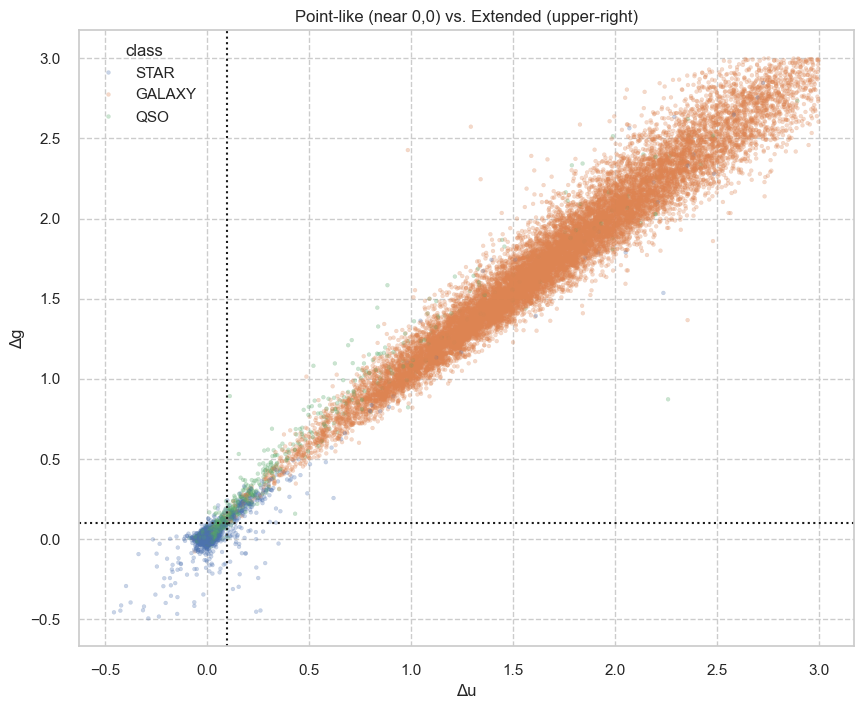

In [12]:
# --- Visualization 2: 2D Cluster Analysis ---
plot_data_filtered = df_processed[(df_processed['Δu'] > -0.5) & (df_processed['Δu'] < 3) & (df_processed['Δg'] > -0.5) & (df_processed['Δg'] < 3)].copy()

# Sample the data if it's still too large to plot clearly
if len(plot_data_filtered) > 30000:
    plot_data_sample = plot_data_filtered.sample(30000, random_state=42)
else:
    plot_data_sample = plot_data_filtered

# --- Scatter plot ---
plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_data_sample, x='Δu', y='Δg', hue='class', alpha=0.3, s=8, edgecolor=None)
plt.axvline(0.1, ls=':', c='k')
plt.axhline(0.1, ls=':', c='k')
plt.xlabel('Δu')
plt.ylabel('Δg')
plt.title('Point-like (near 0,0) vs. Extended (upper-right)')
plt.grid(True, linestyle='--')
plt.show()

### 2.5 Redshift

Redshift is a measure of how much light an object has been stretched to longer wavelengths. For distant objects outside our galaxy, this stretching is primarily caused by the expansion of the universe. According to Hubble's Law, a higher redshift corresponds to a greater distance. This makes redshift an important feature for distinguishing between different types of objects.

Visualizing the redshift distribution for each class will reveal three distinct patterns. Stars will have a redshift distribution peaked at zero. Galaxies will show a distribution at low to moderate positive redshifts. QSOs will have a much broader distribution that extends to significantly higher redshift values, confirming that redshift is a strong feature for classifying these objects.

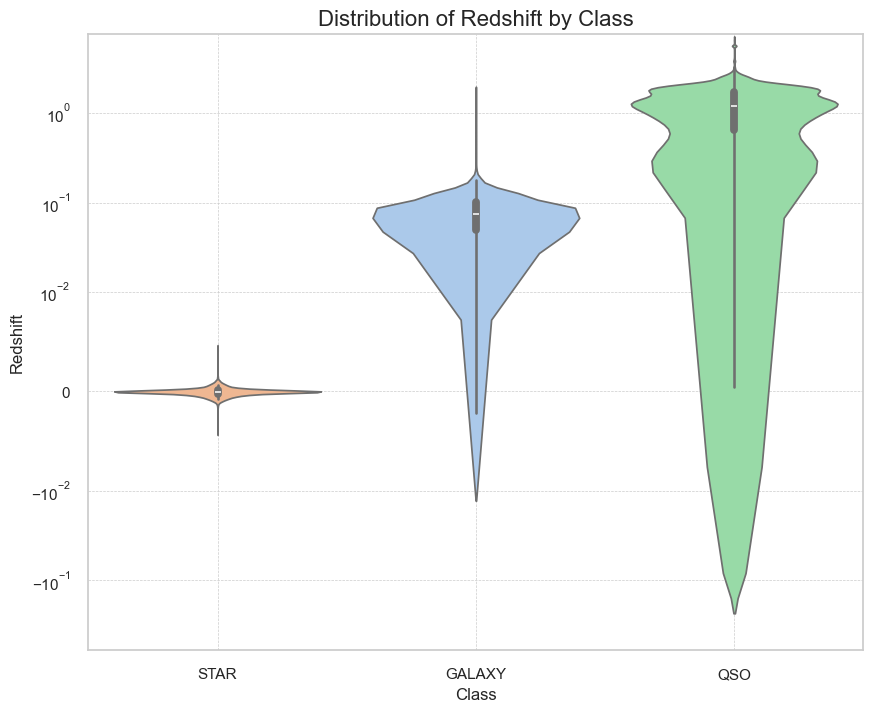

In [13]:
# --- Violin Plot ---
plt.figure(figsize=(10, 8))
sns.violinplot(data=dataset, x='class', y='redshift', hue='class', palette='pastel', order=['STAR', 'GALAXY', 'QSO'], legend=False)
plt.yscale('symlog', linthresh=0.01)
plt.title("Distribution of Redshift by Class", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Redshift", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### 2.6 Stellar Locus in Color-Color Diagram

Our hypothesis is that the three object classes will occupy distinct regions in the multi-dimensional color space. Stars, in particular, will form a tight, predictable curve known as the "stellar locus", while galaxies and quasars will be clustered in different areas. By plotting different color combinations, we can determine which color indices are most effective for separating classes.\
\
Analysis:
- **(u-g) vs. (g-r)** [Left Plot]: This plot provides the best separation. The stars form a very, tight stellar locus (curved line). The quasar (QSOs) occupy their own distinct cluster, separate from the stars. The galaxies form a larger, more diffuse cloud that overlaps both groups.
- **(g-r) vs. (r-i)** [Center Plot]: More overlap in the diagram, although main clusters are still somewhat visible.
- **(r-i) vs. (i-z)** [Right Plot]: This plot shows almost complete overlap between stars, galaxies, and quasars. As we reasoned earlier, these filters (r, i, z) are all in the red/infrared part of the spectrum, so the color differences between them are not distinct enough to separate the classes.

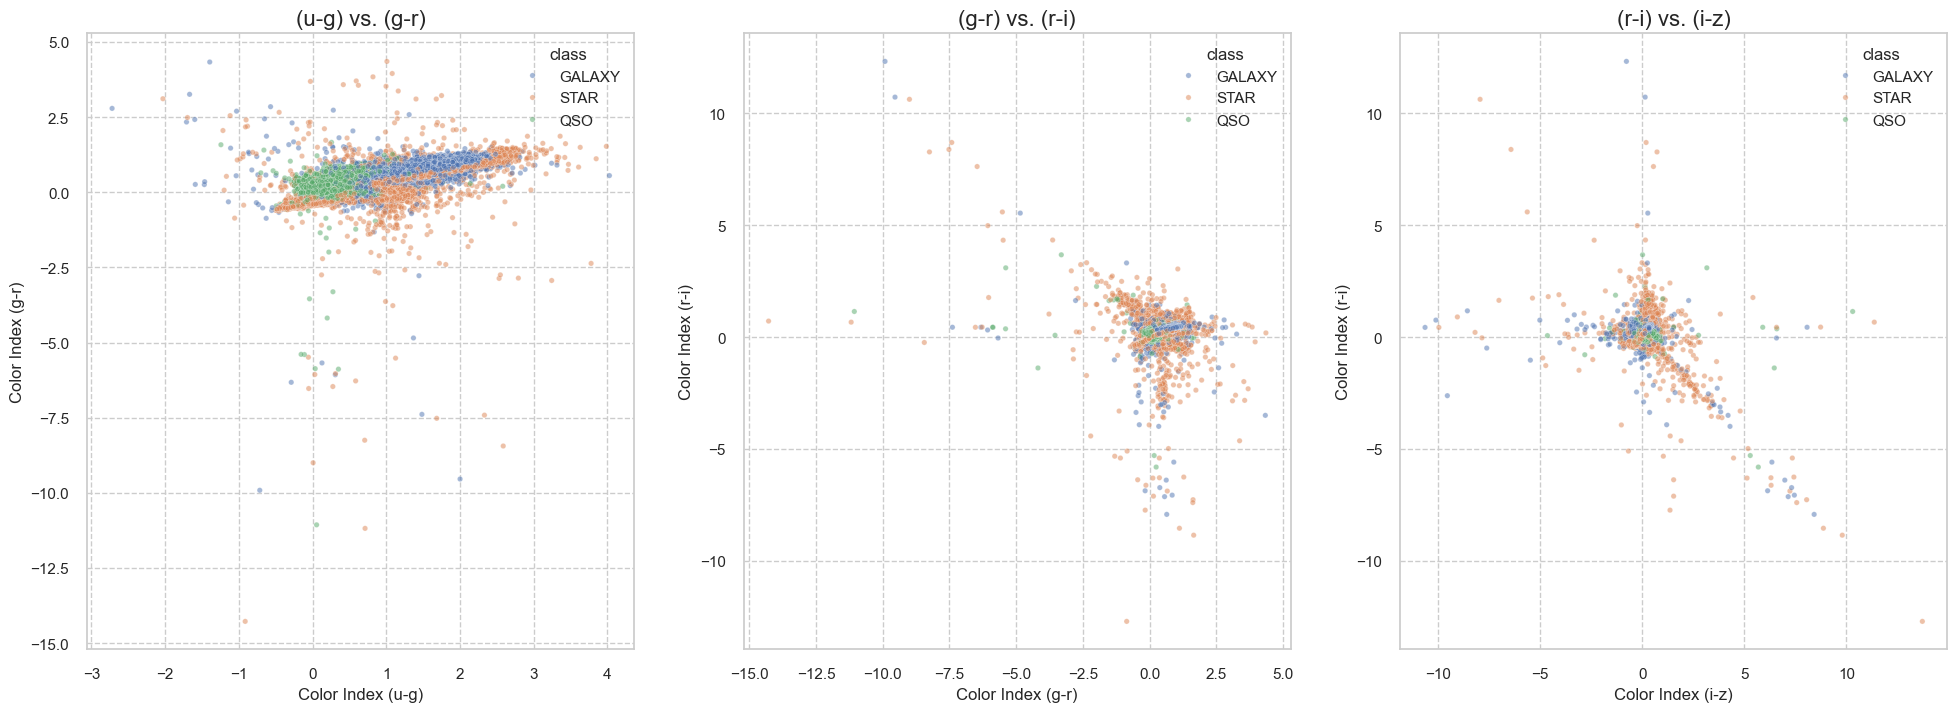

In [14]:
# --- Create the Figure with 3 Subplots in 1 Row ---
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# --- Creating color indices ---
df_processed['u-g'] = df_processed['u'] - df_processed['g']
df_processed['g-r'] = df_processed['g'] - df_processed['r']
df_processed['r-i'] = df_processed['r'] - df_processed['i']
df_processed['i-z'] = df_processed['i'] - df_processed['z']

# --- Plot 1: (u-g) vs. (g-r) ---
sns.scatterplot(data=df_processed, x='u-g', y='g-r', hue='class', alpha=0.5, s=15, ax=axes[0])
axes[0].set_title('(u-g) vs. (g-r)', fontsize=16)
axes[0].set_xlabel('Color Index (u-g)', fontsize=12)
axes[0].set_ylabel('Color Index (g-r)', fontsize=12)
axes[0].grid(True, which='both', linestyle='--')

# --- Plot 2: (g-r) vs. (r-i) ---
sns.scatterplot(data=df_processed, x='g-r', y='r-i', hue='class', alpha=0.5, s=15, ax=axes[1])
axes[1].set_title('(g-r) vs. (r-i)', fontsize=16)
axes[1].set_xlabel('Color Index (g-r)', fontsize=12)
axes[1].set_ylabel('Color Index (r-i)', fontsize=12)
axes[1].grid(True, which='both', linestyle='--')

# --- Plot 3: (r-i) vs. (i-z) ---
sns.scatterplot(data=df_processed, x='i-z', y='r-i', hue='class', alpha=0.5, s=15, ax=axes[2])
axes[2].set_title('(r-i) vs. (i-z)', fontsize=16)
axes[2].set_xlabel('Color Index (i-z)', fontsize=12)
axes[2].set_ylabel('Color Index (r-i)', fontsize=12)
axes[2].grid(True, which='both', linestyle='--')

plt.show()

### 2.7 Outlier Boxplots

Before we feed the data to a model, it's important to understand the distribution of each feature and check for outliers. Extreme values can sometimes skew a model's training process or violate its assumptions (especially for scaling or linear models). Since we are training Random Forest and XGBoost, we don't need to worry about outliers in our dataaset.

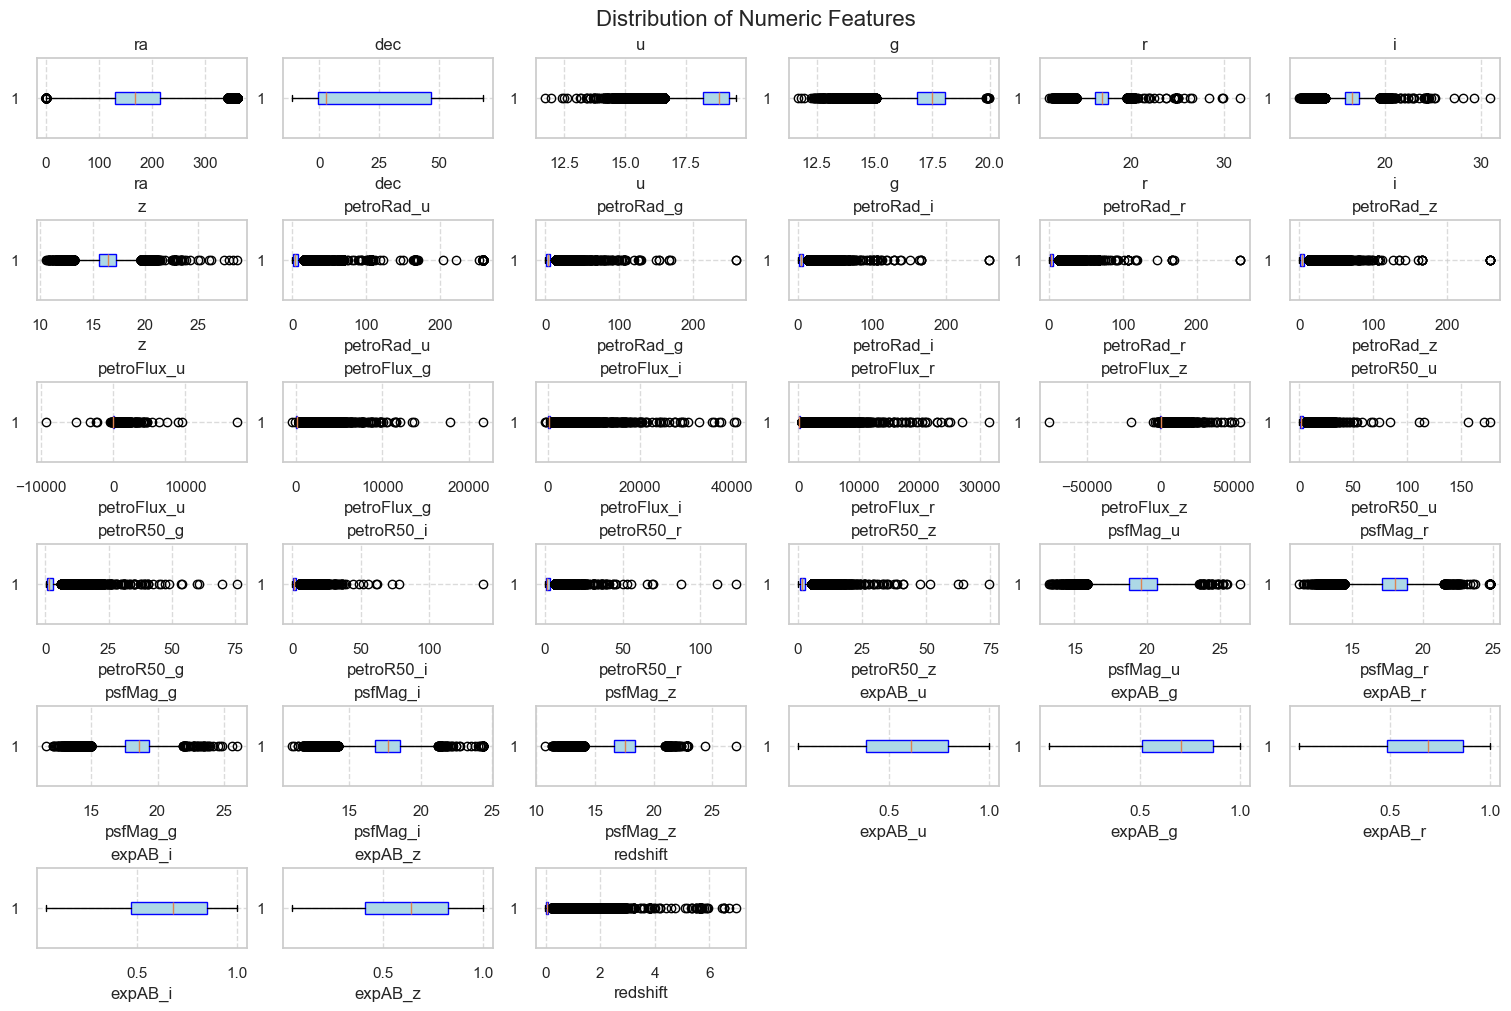

In [15]:
# --- Detect any outliers with boxplots ---
numeric_columns = dataset.select_dtypes(include=["float64"]).columns
grid_size = math.ceil(math.sqrt(len(numeric_columns)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

for idx, col in enumerate(numeric_columns):
    axes[idx].boxplot(dataset[col].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor="lightblue", color="blue"))
    axes[idx].set_title(f"{col}")
    axes[idx].set_xlabel(col)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

for i in range(len(numeric_columns), len(axes)):
    axes[i].axis(('off'))

plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()

## 3 Data Preprocessing for Modeling

This process involves several key steps designed to maximize the models' performances and prevent any data leakage.

In [16]:
# --- Encode Using Label Encoding ---
le = LabelEncoder()
dataset['class'] = le.fit_transform(dataset['class'])
df_processed['class'] = le.fit_transform(df_processed['class'])
labels = df_processed['class']

In [17]:
# --- Base Model Dataset ---

# 1. Define BASE features
base_features_cols = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'petroRad_u', 'petroRad_g',
       'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g',
       'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g',
       'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r',
       'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r',
       'expAB_i', 'expAB_z', 'redshift']

features_base = df_processed[base_features_cols]

# 2. Split the BASE dataset
X_train, X_test, y_train, y_test = train_test_split(features_base, labels, test_size=0.2, stratify=labels, random_state=42)

In [18]:
# --- Feature Engineered Model Dataset ---
# Color indices: (u-g), (g-r), (r-i), (i-z)
# Extended vs. point-source: (psfMag_u - u), (psfMag_g - g), (psfMag_r - r), (psfMag_i - i), (psfMag_z - z)
# Redshift (NOT feature engineerd): Powerful variable that differentiates quasars

# 1. Define Feature Engineered features
eng_feature_col = ['ra', 'dec', 'u-g', 'g-r', 'r-i', 'i-z', 'Δu', 'Δg', 'Δr', 'Δi', 'Δz',
       'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 
       'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z', 
       'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z', 'redshift']

features_eng = df_processed[eng_feature_col]

# 2. Split the ENGINEERED dataset
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(features_eng, labels, test_size=0.2, stratify=labels, random_state=42)

In [19]:
# --- Make sure to replace NaN's with median values ---

# === IMPUTE FOR BASE MODEL ===
imputer_base = SimpleImputer(strategy='median')
X_train_base_imputed = imputer_base.fit_transform(X_train)
X_test_base_imputed = imputer_base.transform(X_test)

# Convert back
X_train = pd.DataFrame(X_train_base_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_base_imputed, columns=X_test.columns)

# === IMPUTE FOR FEATURE ENGINEERED MODEL ===
imputer_eng = SimpleImputer(strategy='median')
X_train_eng_imputed = imputer_eng.fit_transform(X_train_eng)
X_test_eng_imputed = imputer_eng.transform(X_test_eng)

X_train_eng = pd.DataFrame(X_train_eng_imputed, columns=X_train_eng.columns)
X_test_eng = pd.DataFrame(X_test_eng_imputed, columns=X_test_eng.columns)

In [20]:
# === BASE ===

# --- 1. Feature Scaling (BEFORE SMOTE) ---
# Initialize a new scaler for the base dataset
scaler_base = RobustScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train)
X_test_base_scaled = scaler_base.transform(X_test)

# --- 2. Apply SMOTE (ONLY to the scaled training data) ---
smote = SMOTE(random_state=42)
X_train_base_resampled, y_train_base_resampled = smote.fit_resample(X_train_base_scaled, y_train)

print("Base Model - Before SMOTE:", X_train_base_scaled.shape)
print("Base Model - After SMOTE:", X_train_base_resampled.shape)

Base Model - Before SMOTE: (80000, 33)
Base Model - After SMOTE: (125622, 33)


In [21]:
# === FEATURE ENGINEERED ===

# --- 1. Feature Scaling (BEFORE SMOTE) ---
scaler_eng = RobustScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_eng)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)

# --- 2. Apply SMOTE (ONLY to the scaled training data) ---
smote = SMOTE(random_state=42)
X_train_eng_resampled, y_train_eng_resampled = smote.fit_resample(X_train_eng_scaled, y_train_eng)

print("Eng. Model - Before SMOTE:", X_train_eng_scaled.shape)
print("Eng. Model - After SMOTE:", X_train_eng_resampled.shape)

Eng. Model - Before SMOTE: (80000, 27)
Eng. Model - After SMOTE: (125622, 27)


## 4 Model Training, Tuning, and Final Evaluation

Flowchart:
- Train the base and feature engineered models
- Pick best model and hyperparameter tuning with Optuna
- Train the final model
- Final evaluations

### 4.1 Base Model and Feature Engineered Model

In [22]:
# --- BASE MODEL ---
rf_base = RandomForestClassifier(n_estimators=600, n_jobs=-1, random_state=42)
rf_base.fit(X_train_base_resampled, y_train_base_resampled)
preds_base = rf_base.predict(X_test_base_scaled)

# Evaluation Random Forest
rf_conf_matrix = confusion_matrix(y_test, preds_base)
rf_acc_score = accuracy_score(y_test, preds_base)
rf_macro_f1 = f1_score(y_test, preds_base, average="macro")
rf_class_report = classification_report(y_test, preds_base)

print("\n--- BASE MODEL RESULTS ---")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Accuracy:", rf_acc_score * 100,'\n')
print("Random Forest Macro-F1:", rf_macro_f1 * 100, '\n')
print("Random Forest Classification Report:\n", rf_class_report)


--- BASE MODEL RESULTS ---
Random Forest Confusion Matrix:
 [[10382    49    38]
 [   77  2008     0]
 [    8     0  7438]]
Random Forest Accuracy: 99.14 

Random Forest Macro-F1: 98.60939008162487 

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     10469
           1       0.98      0.96      0.97      2085
           2       0.99      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [23]:
# --- FEATURE ENGINEERED MODEL ---
rf_eng = RandomForestClassifier(n_estimators=600, n_jobs=-1, random_state=42)
rf_eng.fit(X_train_eng_resampled, y_train_eng_resampled)
preds_eng = rf_eng.predict(X_test_eng_scaled)

# Evaluation Feature Engineer
rf_conf_matrix = confusion_matrix(y_test_eng, preds_eng)
rf_acc_score = accuracy_score(y_test_eng, preds_eng)
rf_macro_f1 = f1_score(y_test_eng, preds_eng, average="macro")
rf_class_report = classification_report(y_test_eng, preds_eng)

print("\n--- ENGINEERED MODEL RESULTS ---")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Accuracy:", rf_acc_score * 100,'\n')
print("Random Forest Macro-F1:", rf_macro_f1 * 100, '\n')
print("Random Forest Classification Report:\n", rf_class_report)


--- ENGINEERED MODEL RESULTS ---
Random Forest Confusion Matrix:
 [[10402    44    23]
 [   68  2017     0]
 [    4     0  7442]]
Random Forest Accuracy: 99.30499999999999 

Random Forest Macro-F1: 98.81794014544755 

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     10469
           1       0.98      0.97      0.97      2085
           2       1.00      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



### 4.2 Analysis
From the results, the feature engineered model performed better than the base model.\
Even though the baseline model was already performing at a very high level, the engineered model demonstrated better.
- Macro F1-Score: Increased from 98.61% -> **98.81%**.
- Overall Accuracy: Increased from 99.14% -> **99.30%**.


While these numbers seem like small improvements, they represent a significant reduction in classification errors.

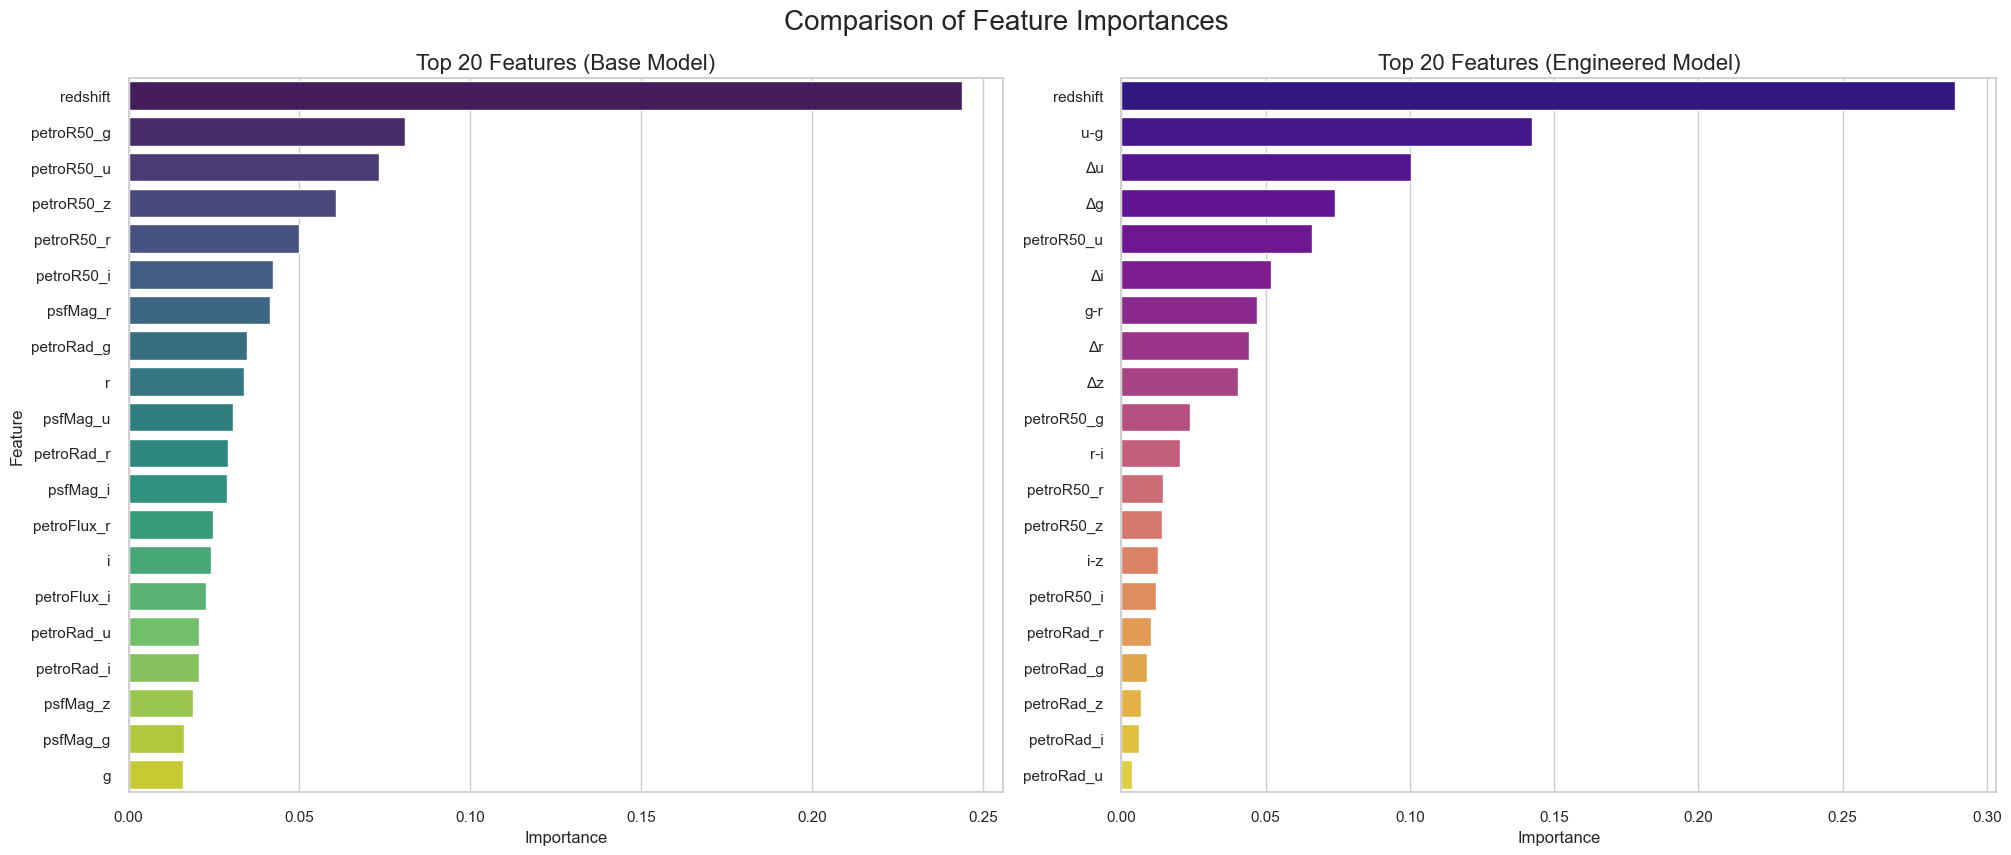

In [24]:
# === Set up FEATURE IMPORTANCE chart ===
fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
fig.suptitle('Comparison of Feature Importances', fontsize=20, y=1.05)

importances_base = rf_base.feature_importances_
features_base = X_train.columns

df_base_imp = pd.DataFrame({'feature': features_base, 'importance': importances_base})
df_base_imp = df_base_imp.sort_values('importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_base_imp, ax=axes[0], palette='viridis', hue='feature', legend=False)
axes[0].set_title('Top 20 Features (Base Model)', fontsize=16)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)

importances_eng = rf_eng.feature_importances_
features_eng = X_train_eng.columns

df_eng_imp = pd.DataFrame({'feature': features_eng, 'importance': importances_eng})
df_eng_imp = df_eng_imp.sort_values('importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_eng_imp, ax=axes[1], palette='plasma', hue='feature', legend=False)
axes[1].set_title('Top 20 Features (Engineered Model)', fontsize=16)
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_ylabel('')

plt.show()

In [25]:
# === 5 fold cross validation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_eng, X_train_eng_scaled, y_train_eng, cv=kf, scoring='f1_macro')

print("--- Feature Engineered Model Performance ---")
print(f"Cross-validation F1 score: {scores}")
print(f"Average F1 score: {np.mean(scores):.4f}")
print(f"Standard deviation of F1 scores: {np.std(scores):.4f}")

--- Feature Engineered Model Performance ---
Cross-validation F1 score: [0.98808009 0.98835484 0.98817153 0.98926736 0.98721739]
Average F1 score: 0.9882
Standard deviation of F1 scores: 0.0007


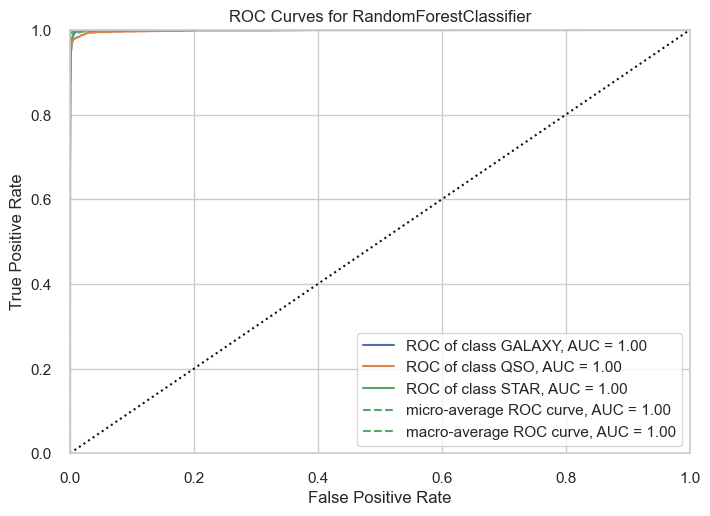

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [26]:
# === ROC Curve ===
visualizer = ROCAUC(rf_eng, classes=le.classes_, is_fitted=True)
visualizer.fit(X_train_eng_scaled, y_train_eng)
visualizer.score(X_test_eng_scaled, y_test_eng)
visualizer.show()

### 4.3 Optuna Hyperparamter Tuning

Automates hyperparameter tuning in great performance. Uses Bayesian optimization algorithm of efficiently explore the hyperparameter space. More effective than the other traditional methods like RandomSearch and GridSearch

In [250]:
# 1. Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'random_state': 42,
        'n_jobs': -1
    }

    # Create the Random Forest model with the suggested hyperparameters
    rf_clf = RandomForestClassifier(**params)

    # Evaluate the model using cross-validation
    # The goal is to maximize the F1-score, which balances precision and recall.
    score = cross_val_score(
        rf_clf, 
        X_train_eng_resampled, 
        y_train_eng_resampled, 
        cv=kf,
        scoring='f1_weighted'
    )
    
    return np.mean(score)

# 2. Create a study object and run the optimization
# We set the direction to 'maximize' because a higher F1-score is better.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials to find the best parameters

[I 2025-09-17 00:42:54,177] A new study created in memory with name: no-name-c0268db0-ce3a-4c3a-b532-cbe39d58d896
[I 2025-09-17 00:44:16,127] Trial 0 finished with value: 0.9898444981635711 and parameters: {'n_estimators': 410, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9898444981635711.
[I 2025-09-17 00:45:16,172] Trial 1 finished with value: 0.9874375017546682 and parameters: {'n_estimators': 315, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.9898444981635711.
[I 2025-09-17 00:45:51,032] Trial 2 finished with value: 0.9866514566729887 and parameters: {'n_estimators': 227, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.9898444981635711.
[I 2025-09-17 00:47:04,231] Trial 3 finished with value: 0.9899159729821381 and parameters: {'n_estimators': 374, 'max_depth': 47, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with v

In [251]:
# --- Optuna hyperparameter tuning results ---
print("Best trial:")
trial = study.best_trial
print(f"  Value (F1-score): {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (F1-score): 0.9920
  Best hyperparameters: 
    n_estimators: 353
    max_depth: 38
    min_samples_split: 6
    min_samples_leaf: 3


### 4.4 Final Model

In [27]:
# 1. Create final model with the best hyperparameters from Optuna.
final_rf_model = RandomForestClassifier(
    n_estimators=353,
    max_depth=38,
    min_samples_split=6,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

# 2. Train model on FULL resampled training data.
final_rf_model.fit(X_train_eng_resampled, y_train_eng_resampled)

# 3. Evaluate final model on test set.
final_preds = final_rf_model.predict(X_test_eng_scaled)

final_con_matrix = confusion_matrix(y_test_eng, final_preds)
final_acc_score = accuracy_score(y_test_eng, final_preds)
final_macro_f1 = f1_score(y_test_eng, final_preds, average="macro")
final_class_report = classification_report(y_test_eng, final_preds)

print("--- Final Tuned Model Performace ---")
print("Random Forest Confusion Matrix:\n", final_con_matrix)
print("Random Forest Accuracy:", final_acc_score * 100,'\n')
print("Random Forest Macro-F1:", final_macro_f1 * 100, '\n')
print("Random Forest Classification Report:\n", final_class_report)

--- Final Tuned Model Performace ---
Random Forest Confusion Matrix:
 [[10394    50    25]
 [   67  2018     0]
 [    7     0  7439]]
Random Forest Accuracy: 99.25500000000001 

Random Forest Macro-F1: 98.75215986847545 

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     10469
           1       0.98      0.97      0.97      2085
           2       1.00      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



### 4.5 XGBoost Model Added

In [ ]:
# --- 1. Initialize the XGBoost Model ---
xgb = XGBClassifier(random_state=42, n_jobs=-1)

# --- 2. Train on the resampled engineered data ---
xgb.fit(X_train_eng_resampled, y_train_eng_resampled)

# --- 3. Evaluate on the scaled test data ---
preds_xgb = xgb.predict(X_test_eng_scaled)

# --- 4. Print Full Results ---
xgb_matrix = confusion_matrix(y_test_eng, preds_xgb)
xgb_acc_score = accuracy_score(y_test_eng, preds_xgb)
xgb_macro_f1 = f1_score(y_test_eng, preds_xgb, average="macro")
xgb_class_report = classification_report(y_test_eng, preds_xgb)

print("--- XGBoost Model Performace ---")
print("XGBoost Confusion Matrix:\n", xgb_matrix)
print("XGBoost Accuracy:", xgb_acc_score * 100,'\n')
print("XGBoost Macro-F1:", xgb_macro_f1 * 100, '\n')
print("XGBoost Classification Report:\n", xgb_class_report)

--- XGBoost Model Performace ---
XGBoost Confusion Matrix:
 [[10393    40    36]
 [   60  2025     0]
 [    3     0  7443]]
XGBoost Accuracy: 99.30499999999999 

XGBoost Macro-F1: 98.88825924423786 

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     10469
           1       0.98      0.97      0.98      2085
           2       1.00      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



# Conclusion